## IMPORT PRE-PROCESSED DATA & SUBSET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('NSDUH PROCESSED2.csv')

C:\Users\david\AppData\Local\Temp\ipykernel_9352\2478691757.py:1: DtypeWarning: Columns (4,7,10,22,25,34,37,38,39,41,42,43,45,46,47,49,50,51,57,58,59,61,62,63,64,66,67,68,69,70,85,87,89,90,92,93,110,113,118,119,120,137,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NSDUH PROCESSED2.csv')


In [4]:
df = df.applymap(str)

In [5]:
for cols in df.columns:
    mask = (df[cols] == 'nan')
    
    df.loc[mask, cols] = np.nan

In [6]:
#check number of columns with missing data
len(df.columns[df.isnull().any()])

129

In [7]:
df.head()

,CIGEVER,CIGTRY,CIGREC,CIGAGE,CIGAREVR,CIGARTRY,CIGARREC,SMKLSSEVR,SMKLSSTRY,SMKLSSREC,...,CHAMPUS,PRVHLTIN,CELLWRKNG,GOVTPROG,INCOME,PDEN10,COUTYP4,MAIIN102,AIIND102,METHAMEVR
0,1,less than 18,1,18 or older,1,18 or older,4,1,less than 18,1,...,2,1,1,0,4,3,3,0,0,0
1,1,less than 18,1,18 or older,2,0,0,1,less than 18,4,...,2,1,1,0,3,2,2,0,0,0
2,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,2,1,1,0,0,0
3,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,4,1,1,0,0,0
4,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,2,2,2,0,0,0


In [8]:
df = df.dropna()

In [9]:
#check number of columns with missing data
len(df.columns[df.isnull().any()])

0

In [10]:
df_backup = df.copy()

In [11]:
# df = df_backup.copy()

In [20]:
df['METHAMEVR'].value_counts()

Has Not Used Meth    22306
Has Used Meth         1148
Name: METHAMEVR, dtype: int64

In [12]:
df['COCAGE'].value_counts()

0               20146
18 or older      2655
less than 18      650
unknown             3
Name: COCAGE, dtype: int64

# PYCARET MODELING

In [14]:
from pycaret.classification import *

In [15]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=123)
SMOTE = SMOTE(sampling_strategy='minority', random_state=123)

## OVER sampling

In [16]:
s = setup(df, target = 'METHAMEVR',  session_id=123, silent=True, fix_imbalance=True, 
          fix_imbalance_method=oversample,
          imputation_type = 'iterative', categorical_iterative_imputer='knn')

,Description,Value
0,session_id,123
1,Target,METHAMEVR
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(23454, 158)"
5,Missing Values,0
6,Numeric Features,0
7,Categorical Features,157
8,Ordinal Features,0
9,High Cardinality Features,0


In [17]:
from sklearn.metrics import average_precision_score
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')

Name                                                               APC
Display Name                                                       APC
Score Function       <function average_precision_score at 0x0000021...
Scorer               make_scorer(average_precision_score, needs_pro...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: apc, dtype: object

In [18]:
#due to imbalance learning problem, our chosen metric for comparison is the F1-score
best = compare_models(sort='APC', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8926,0.9470,0.8560,0.2886,0.4313,0.3879,0.4587,0.5612,3.1820
et,Extra Trees Classifier,0.9592,0.9369,0.1979,0.7780,0.3132,0.2998,0.3775,0.5489,1.3480
rf,Random Forest Classifier,0.9598,0.9417,0.3123,0.6696,0.4241,0.4061,0.4390,0.5486,0.9130
catboost,CatBoost Classifier,0.9470,0.9380,0.5924,0.4590,0.5156,0.4882,0.4935,0.5295,3.5080
lightgbm,Light Gradient Boosting Machine,0.9335,0.9396,0.6979,0.3897,0.4994,0.4670,0.4901,0.5271,0.3190
ada,Ada Boost Classifier,0.8950,0.9380,0.8212,0.2884,0.4266,0.3833,0.4477,0.5267,0.7920
lr,Logistic Regression,0.8944,0.9240,0.7969,0.2825,0.4170,0.3732,0.4346,0.4839,8.1260
xgboost,Extreme Gradient Boosting,0.9490,0.9253,0.5152,0.4683,0.4888,0.4621,0.4637,0.4802,5.3820
lda,Linear Discriminant Analysis,0.8929,0.9246,0.8149,0.2824,0.4193,0.3753,0.4401,0.4649,1.2890
knn,K Neighbors Classifier,0.9407,0.7445,0.3984,0.3809,0.3882,0.3572,0.3579,0.2409,14.2190


In [19]:
print(best)

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     

In [18]:
evaluate_model(best[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Catboost

In [19]:
cat = create_model('catboost', return_train_score = True)

In [23]:
tuned_cat, tuner = tune_model(cat, optimize='F1', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9464,0.9436,0.5641,0.4490,0.5000,0.4721,0.4755
1,0.9446,0.9320,0.5256,0.4316,0.4740,0.4450,0.4474
2,0.9397,0.9321,0.5641,0.4037,0.4706,0.4396,0.4465
3,0.9507,0.9382,0.6026,0.4845,0.5371,0.5114,0.5148
4,0.9458,0.9158,0.5897,0.4466,0.5083,0.4802,0.4854
5,0.9470,0.9474,0.5513,0.4526,0.4971,0.4694,0.4720
6,0.9610,0.9433,0.6410,0.5814,0.6098,0.5893,0.5901
7,0.9586,0.9563,0.6234,0.5517,0.5854,0.5636,0.5648
8,0.9458,0.9185,0.5065,0.4333,0.4671,0.4387,0.4402


In [ ]:
print(tuner)

In [22]:
#compare tuned model with default
print('Default: ', cat)
print('Tuned: ', tuned_cat)

Default:  <catboost.core.CatBoostClassifier object at 0x000001A0CF24DA90>
Tuned:  <catboost.core.CatBoostClassifier object at 0x000001A0CF24D370>


In [24]:
evaluate_model(tuned_cat)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

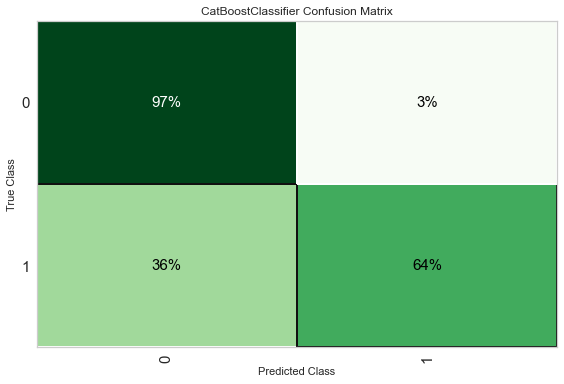

In [25]:
plot_model(tuned_cat, plot='confusion_matrix', plot_kwargs = {'percent': True})

### EDA

In [99]:
df2 = df.loc[:, ['COCAGE', 'METHAMEVR', 'HALLUCREC', 'MJAGE', 'BOOKED', 'CIGREC', 'MILSTAT', 'COUTYP4', 'INCOME', 'ADDPREV',
                 'MAIIN102','COCNEEDL', 'COCEVER', 'CIGAGE', 'CIGTRY', 'AGE2']]

In [100]:
df2.loc[df2['METHAMEVR'] == '1', 'METHAMEVR'] = 'Has Used Meth'
df2.loc[df2['METHAMEVR'] == '0', 'METHAMEVR'] = 'Has Not Used Meth'

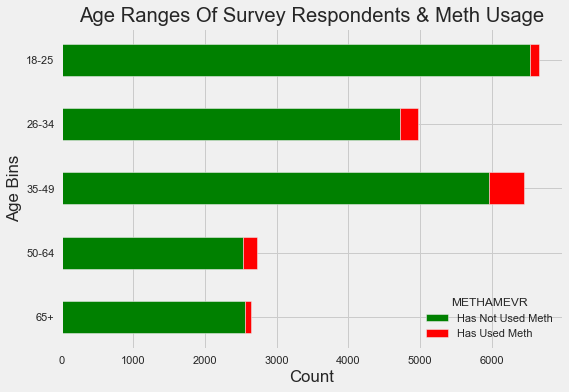

In [102]:
df2.groupby(['AGE2','METHAMEVR']).size().unstack().sort_values(by='AGE2', ascending=False).plot(kind='barh', stacked=True, color=['green', 'red'])
plt.title('AGE RANGES OF SURVEY RESPONDENTS & METH USAGE'.title())
plt.xlabel('Count')
plt.ylabel('Age Bins')
plt.show()

In [103]:
df2.loc[df2['INCOME'] == '1', 'INCOME'] = '$0-$20,000'
df2.loc[df2['INCOME'] == '2', 'INCOME'] = '$20,000-$49,999'
df2.loc[df2['INCOME'] == '3', 'INCOME'] = '$50,000-$74,999'
df2.loc[df2['INCOME'] == '4', 'INCOME'] = '$75,000+'

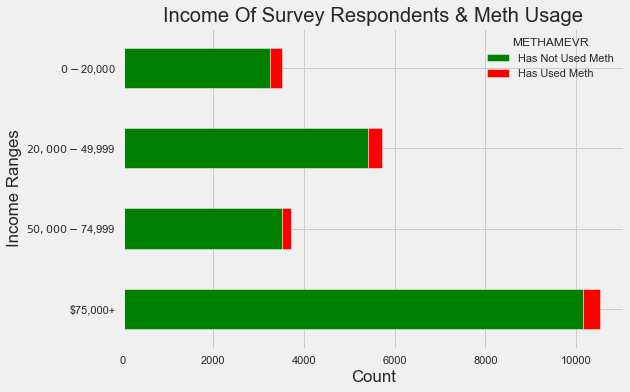

In [104]:
df2.groupby(['INCOME','METHAMEVR']).size().unstack().sort_values(by='INCOME', ascending=False).plot(kind='barh', stacked=True, color=['green', 'red'])
plt.title('INCOME OF SURVEY RESPONDENTS & METH USAGE'.title())
plt.xlabel('Count')
plt.ylabel('Income Ranges')
plt.show()

In [105]:
df2.loc[df2['MAIIN102'] == '1', 'MAIIN102'] = 'American-Indian Area'
df2.loc[df2['MAIIN102'] == '0', 'MAIIN102'] = 'Non American-Indian Area'

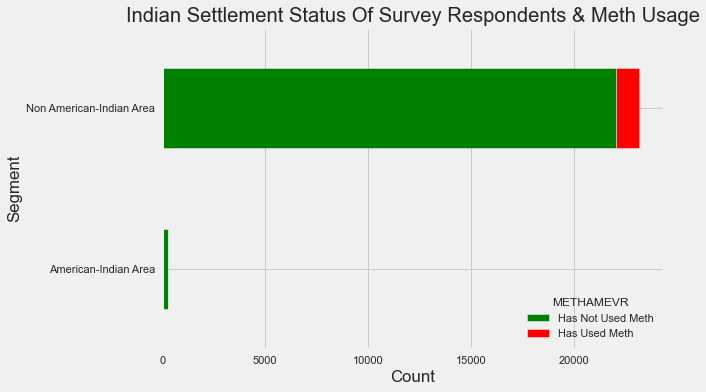

In [106]:
df2.groupby(['MAIIN102','METHAMEVR']).size().unstack().sort_values(by='MAIIN102', ascending=True).plot(kind='barh', stacked=True, color=['green', 'red'])
plt.title('INDIAN SETTLEMENT STATUS OF SURVEY RESPONDENTS & METH USAGE'.title())
plt.ylabel('Segment')
plt.xlabel('Count')
plt.show()

In [107]:
df2.loc[df2['COUTYP4'] == '1', 'COUTYP4'] = 'Large Metro'
df2.loc[df2['COUTYP4'] == '2', 'COUTYP4'] = 'Small Metro'
df2.loc[df2['COUTYP4'] == '3', 'COUTYP4'] = 'Non Metro'

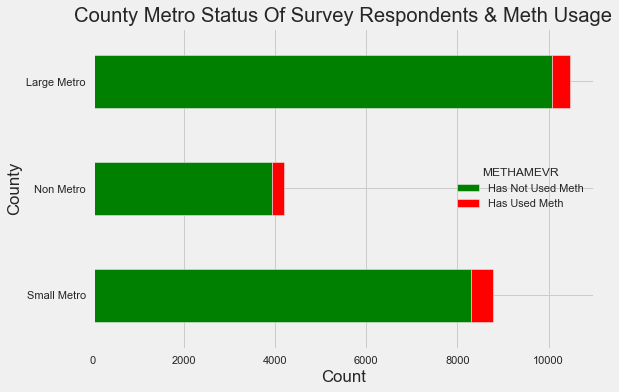

In [108]:
df2.groupby(['COUTYP4','METHAMEVR']).size().unstack().sort_values(by='COUTYP4', ascending=False).plot(kind='barh', stacked=True, color=['green', 'red'])
plt.title('COUNTY METRO STATUS OF SURVEY RESPONDENTS & METH USAGE'.title())
plt.ylabel('County')
plt.xlabel('Count')
plt.show()

In [110]:
df2.loc[df2['COCAGE'] == '0', 'COCAGE'] = 'Never Used'

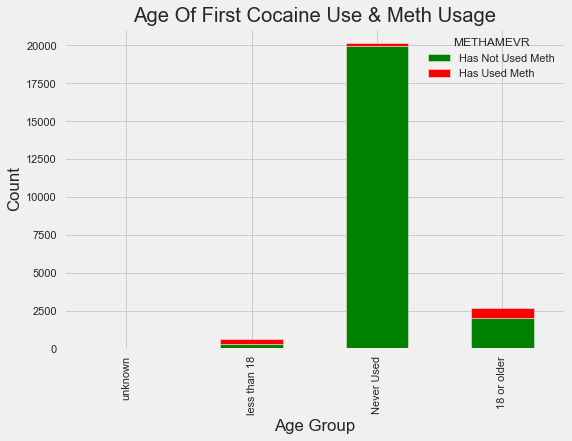

In [140]:
df2.groupby(['COCAGE','METHAMEVR']).size().unstack().sort_values(by='COCAGE', ascending=False).plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('AGE OF FIRST COCAINE USE & METH USAGE'.title())
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.show()

In [118]:
df2.loc[df2['BOOKED'] == '1', 'BOOKED'] = 'Has Been Booked'
df2.loc[df2['BOOKED'] == '2', 'BOOKED'] = 'Has Not Been Booked'

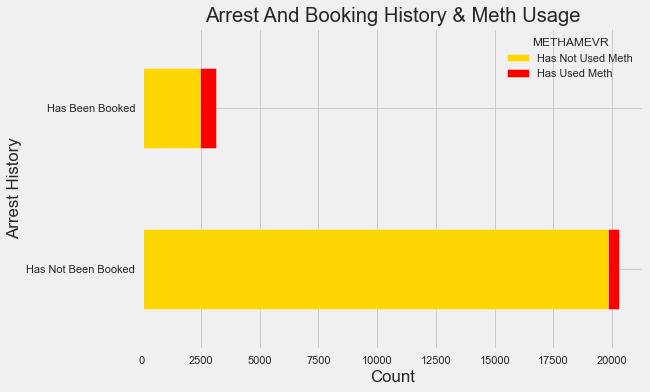

In [123]:
df2.groupby(['BOOKED','METHAMEVR']).size().unstack().sort_values(by='BOOKED', ascending=False).plot(kind='barh', stacked=True, color=['gold', 'red'])
plt.title('ARREST AND BOOKING HISTORY & METH USAGE'.title())
plt.ylabel('Arrest History')
plt.xlabel('Count')
plt.show()

In [130]:
df2.loc[df2['MJAGE'] == '0', 'MJAGE'] = 'Never Used'

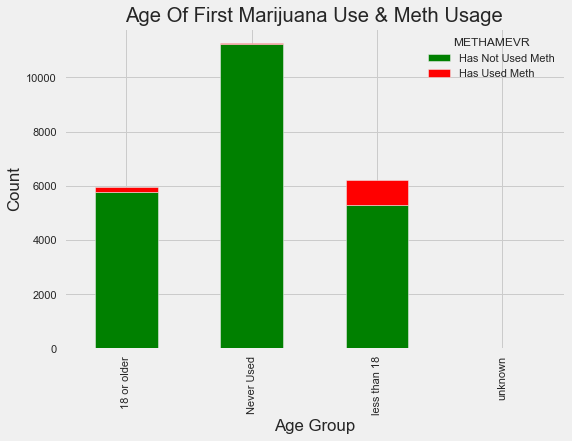

In [139]:
df2.groupby(['MJAGE','METHAMEVR']).size().unstack().sort_values(by='MJAGE', ascending=True).plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('AGE OF FIRST MARIJUANA USE & METH USAGE'.title())
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.show()

In [135]:
df2.loc[df2['HALLUCREC'] == '0', 'HALLUCREC'] = 'Never Used'
df2.loc[df2['HALLUCREC'] == '1', 'HALLUCREC'] = 'Within 30days'
df2.loc[df2['HALLUCREC'] == '2', 'HALLUCREC'] = 'Within past Year'
df2.loc[df2['HALLUCREC'] == '3', 'HALLUCREC'] = 'Over 1 year'

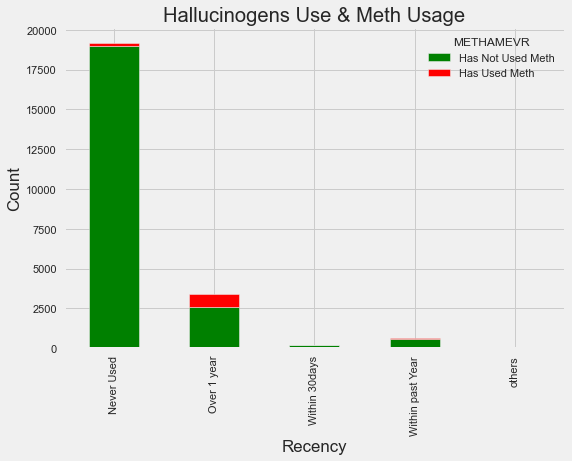

In [138]:
df2.groupby(['HALLUCREC','METHAMEVR']).size().unstack().sort_values(by='HALLUCREC', ascending=True).plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('HALLUCINOGENS USE & METH USAGE'.title())
plt.ylabel('Count')
plt.xlabel('Recency')
plt.show()

### Random Forest

In [33]:
#Focus on Tree Based Ensembles so we can evaluate feature importance
#random forest
rf = create_model('rf', return_train_score=True)

In [27]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [34]:
#tune rf
tuned_rf, tuner = tune_model(rf, optimize = 'F1',  return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.8879,0.9505,0.8462,0.2773,0.4177,0.3728,0.4448,0.5739
1,0.8879,0.9360,0.8205,0.2735,0.4103,0.3650,0.4331,0.6038
2,0.8806,0.9370,0.8205,0.2602,0.3951,0.3480,0.4197,0.4498
3,0.8989,0.9541,0.8718,0.3036,0.4503,0.4087,0.4785,0.5400
4,0.8892,0.9296,0.8077,0.2739,0.4091,0.3640,0.4296,0.5140
5,0.8812,0.9589,0.8974,0.2724,0.4179,0.3721,0.4554,0.6128
6,0.9032,0.9522,0.8590,0.3116,0.4573,0.4167,0.4820,0.5437
7,0.9013,0.9527,0.8442,0.3023,0.4452,0.4040,0.4690,0.6157
8,0.8995,0.9397,0.8442,0.2982,0.4407,0.3990,0.4650,0.4948


In [35]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Random Forest Classifier,0.8907,0.9540,0.8946,0.3120,0.4626,0.4172,0.4897,0.5944


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.8716
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.7218
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.6931
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.6639
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.7233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5790
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.6797
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5248
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5819


In [ ]:
print(tuner)

In [30]:
#compare tuned rf with default
print('Default: ', rf)
print('Tuned: ', tuned_rf)

Default:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
Tuned:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
              

In [31]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

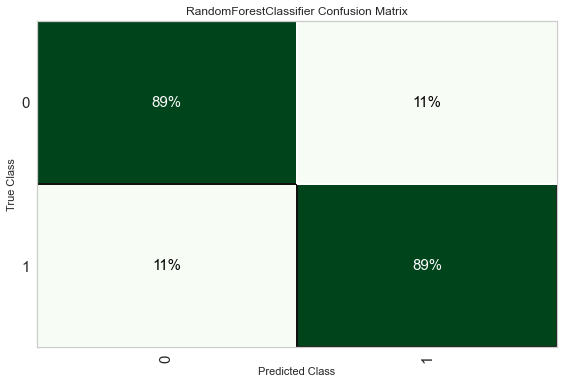

In [36]:
plot_model(tuned_rf, plot='confusion_matrix', plot_kwargs = {'percent': True})

### GBC

In [20]:
#gbc
gbc = create_model('gbc', return_train_score=True)

In [21]:
#tune gbc
tuned_gbc, tuner = tune_model(gbc, optimize='APC', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.8782,0.9510,0.8846,0.2654,0.4083,0.3616,0.4443,0.5629
1,0.8764,0.9377,0.7949,0.2490,0.3792,0.3308,0.4005,0.6061
2,0.8709,0.9424,0.8718,0.2519,0.3908,0.3423,0.4262,0.4586
3,0.8910,0.9575,0.9103,0.2922,0.4424,0.3992,0.4794,0.5426
4,0.8800,0.9341,0.8333,0.2610,0.3976,0.3506,0.4244,0.5305
5,0.8715,0.9563,0.8974,0.2564,0.3989,0.3509,0.4386,0.5828
6,0.8879,0.9512,0.8846,0.2828,0.4286,0.3842,0.4621,0.5671
7,0.8915,0.9579,0.8961,0.2887,0.4367,0.3937,0.4721,0.6279
8,0.8836,0.9386,0.8571,0.2683,0.4087,0.3632,0.4396,0.5198


In [ ]:
print(tuner)

In [23]:
predict_model(gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.8956,0.9569,0.9081,0.3240,0.4776,0.4337,0.5056,0.6150


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9912
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9681
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9747
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9505
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0.5103
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.9071
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.5066
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0.6040


In [22]:
predict_model(tuned_gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.8809,0.9566,0.9081,0.2947,0.4450,0.3972,0.4770,0.6118


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.5
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5


In [43]:
#compare tuned model with default
print(gbc)
print(tuned_gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1e-07, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.02, min_impurity_split=None

In [24]:
evaluate_model(gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

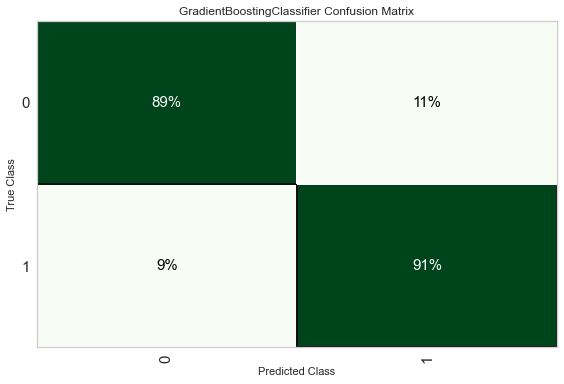

In [46]:
plot_model(gbc, plot='confusion_matrix', plot_kwargs = {'percent': True})

### Adaboost

In [71]:
#adaboost
ada = create_model('ada', return_train_score=True)

In [72]:
#tune catboost
tuned_ada, tuner = tune_model(ada, optimize='F1', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8861,0.9469,0.8590,0.2757,0.4174,0.3723,0.4471
1,0.8916,0.9417,0.8077,0.2788,0.4145,0.3700,0.4343
2,0.8831,0.9434,0.8462,0.2683,0.4074,0.3613,0.4357
3,0.9019,0.9586,0.8718,0.3105,0.4579,0.4171,0.4850
4,0.8971,0.9253,0.7949,0.2884,0.4232,0.3800,0.4395
5,0.8879,0.9529,0.8846,0.2828,0.4286,0.3842,0.4621
6,0.9001,0.9531,0.8718,0.3063,0.4533,0.4120,0.4811
7,0.9037,0.9585,0.8831,0.3134,0.4626,0.4226,0.4918
8,0.9013,0.9404,0.8052,0.2967,0.4336,0.3919,0.4511


In [73]:
print(tuner)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('fix_imbalance',
                                              RandomUnderSampler(random_state=123,
                                                                 replacement=False,
                                                                 sampling_strategy='majority')),
                                             ('actual_estimator',
                                              AdaBoostClassifier(algorithm='SAMME.R',
                                                                 base_estimator=None,
                                                                 learning_rate=1.0,
                                                                 n_estimators=5...
                                                                            1e-06,
            

In [74]:
#compare tuned model with default
print(ada)
print(tuned_ada)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)
AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.2,
                   n_estimators=230, random_state=123)


In [75]:
evaluate_model(tuned_ada)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…